# CHELSA 2010 Mean Temperature and Precipitation

In [2]:
import rioxarray as rio
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


In [3]:
sample_pr = "/home/tkhan/biodt/storage/finetune/chelsa/pr_raw/CHELSA_pr_02_2010_V.2.1.tif"
sample_tas = "/home/tkhan/biodt/storage/finetune/chelsa/tas_raw/CHELSA_tas_02_2010_V.2.1.tif"

# Define Grid: Defines a lat/lon bounding box over Europe/North Africa/West Asia | Creates grid bins every 0.25° for later grouping.
LAT_START, LAT_END = 32.0, 72.0
LON_START, LON_END = -25.0, 45.0
GRID_LAT = np.round(np.arange(LAT_START, LAT_END + 1e-6, 0.25), 3)
GRID_LON = np.round(np.arange(LON_START, LON_END + 1e-6, 0.25), 3)

# Create a mask for the region of interest
#mask = (pr >= 0) & (tas >= -100)  # Assuming valid data is non-negative for pr and above -30 for tas
# Apply the mask to the data
#pr_masked = np.where(mask, pr, np.nan)
#tas_masked = np.where(mask, tas, np.nan)

# Use rioxarray to read the data, squeeze the band to xy-shape
pr_xr = rio.open_rasterio(sample_pr).squeeze("band", drop=True)
tas_xr = rio.open_rasterio(sample_tas).squeeze("band", drop=True)


In [4]:

# Group the data by the defined grid and downsample by taking mean of the bin
pr_xr_coarse = pr_xr.groupby_bins('y', GRID_LAT).mean().groupby_bins('x', GRID_LON).mean()
tas_xr_coarse = tas_xr.groupby_bins('y', GRID_LAT).mean().groupby_bins('x', GRID_LON).mean()



In [5]:
print("Original precipitation: min", float(pr_xr.min()), "max", float(pr_xr.max()), "mean", float(pr_xr.mean()))
print("Coarse precipitation: min", float(pr_xr_coarse.min()), "max", float(pr_xr_coarse.max()), "mean", float(pr_xr_coarse.mean()))

Original precipitation: min 0.0 max 1834980.0 mean 7499.589370026696
Coarse precipitation: min 15.529999999999998 max 68048.17333333332 mean 7777.014932266867


In [6]:
print("Original temperature: min", float(tas_xr.min()), "max", float(tas_xr.max()), "mean", float(tas_xr.mean()))
print("Coarse temperature: min", float(tas_xr_coarse.min()), "max", float(tas_xr_coarse.max()), "mean", float(tas_xr_coarse.mean()))

Original temperature: min 2274.0 max 3102.0 mean 2778.2877563546544
Coarse temperature: min 2507.296666666667 max 2914.837777777778 mean 2751.974793774802


### Grouping validation

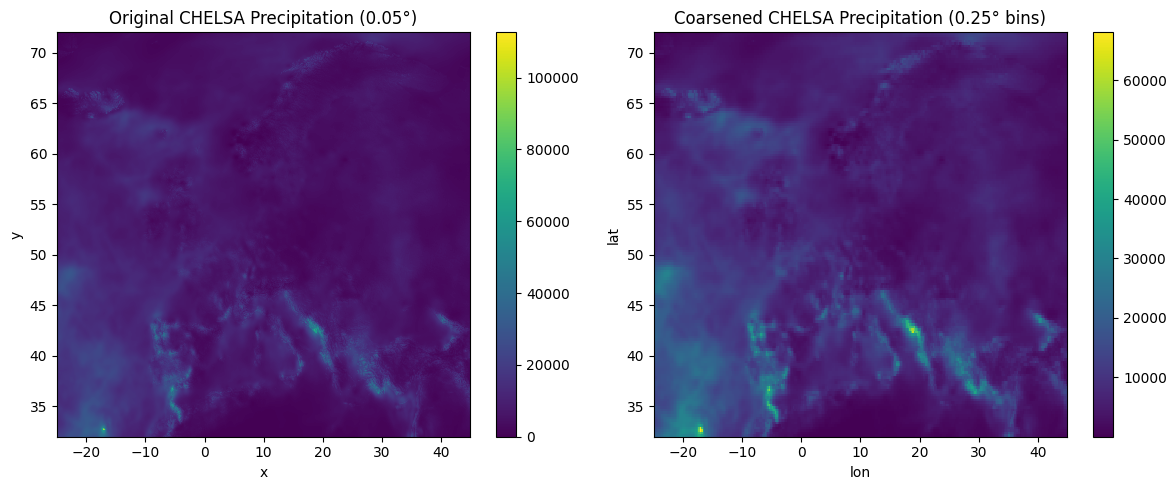

In [19]:
# Spatial crop before plotting
pr_roi = pr_xr.sel(
    y=slice(LAT_END, LAT_START),  # descending order for latitude
    x=slice(LON_START, LON_END)
)
# Plot original CHELSA precipitation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
pr_roi.plot(cmap="viridis")
plt.title("Original CHELSA Precipitation (0.05°)")

# Plot grouped (coarsened) precipitation
plt.subplot(1, 2, 2)
pr_xr_coarse.plot(cmap="viridis")
plt.title("Coarsened CHELSA Precipitation (0.25° bins)")

plt.tight_layout()
plt.show()

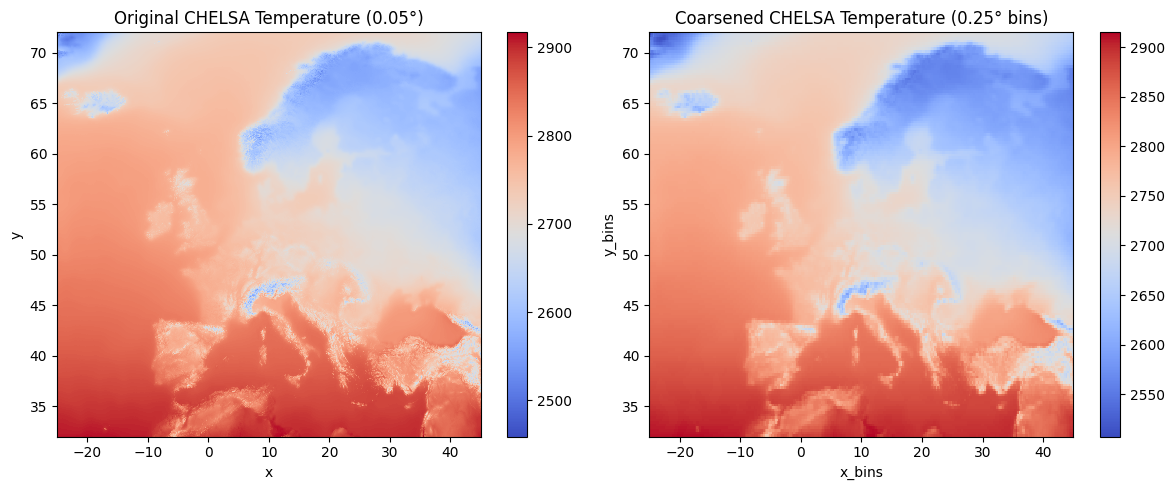

In [20]:
# Spatial crop before plotting
tas_roi = tas_xr.sel(
    y=slice(LAT_END, LAT_START),  # descending order for latitude
    x=slice(LON_START, LON_END)
)

# Plot original CHELSA temperature
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
tas_roi.plot(cmap="coolwarm")
plt.title("Original CHELSA Temperature (0.05°)")

# Plot grouped (coarsened) temperature
plt.subplot(1, 2, 2)
tas_xr_coarse.plot(cmap="coolwarm")
plt.title("Coarsened CHELSA Temperature (0.25° bins)")

plt.tight_layout()
plt.show()

### Plotting final datasets

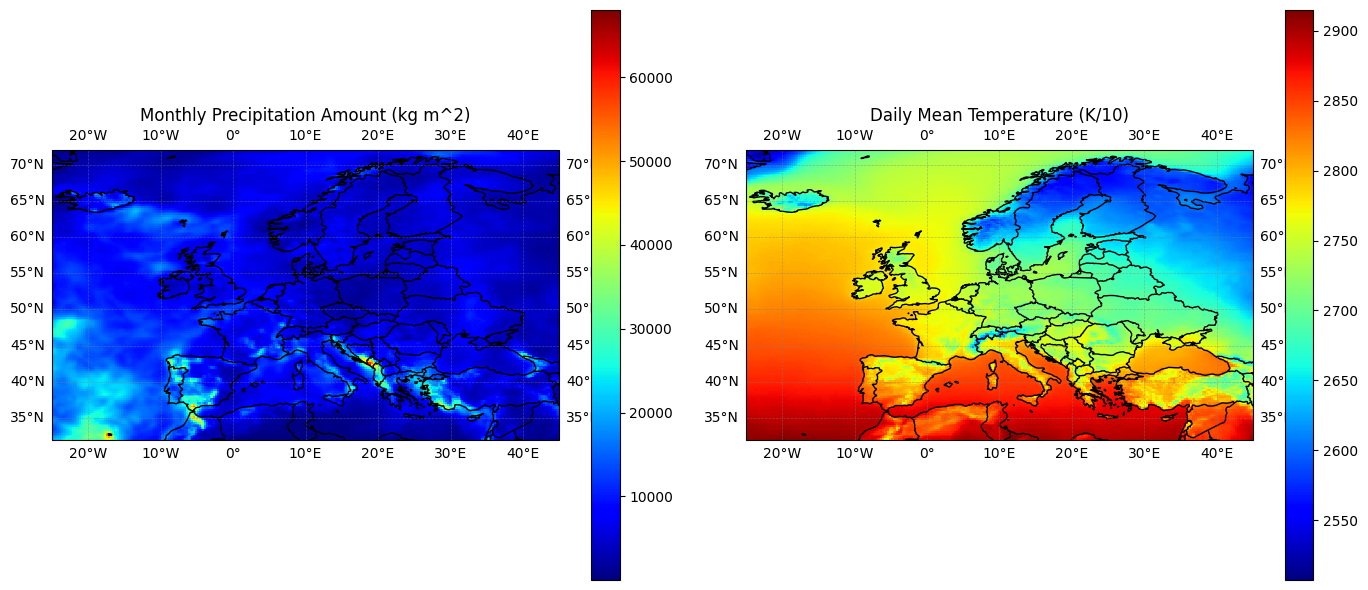

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

pr_xr_coarse = pr_xr_coarse.rename({'x_bins': 'lon', 'y_bins': 'lat'})
fig, axes = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Precipitation plot
pr_xr_coarse.plot(ax=axes[0], cmap="jet", add_colorbar=True, transform=ccrs.PlateCarree())
axes[0].set_title("Monthly Precipitation Amount (kg m^2)")
axes[0].add_feature(cfeature.BORDERS, linewidth=1)
axes[0].add_feature(cfeature.COASTLINE, linewidth=1)
axes[0].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Temperature plot
tas_xr_coarse.plot(ax=axes[1], cmap="jet", add_colorbar=True, transform=ccrs.PlateCarree())
axes[1].set_title("Daily Mean Temperature (K/10)")
axes[1].add_feature(cfeature.BORDERS, linewidth=1)
axes[1].add_feature(cfeature.COASTLINE, linewidth=1)
axes[1].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()

### Read the Batch NetCDF4 file

In [ ]:
ds = xr.open_dataset("/gpfs/work1/0/prjs1134/data/projects/biodt/storage/finetune/chelsa/chelsa_bfm_latents_downsampled.nc")
print(ds)

<xarray.Dataset> Size: 928MB
Dimensions:          (time: 7, pixel: 64400, embedding_dim: 256,
                      target_pixel: 44800, variable: 2)
Coordinates:
  * time             (time) datetime64[ns] 56B 2018-06-01 ... 2018-12-01
  * embedding_dim    (embedding_dim) int64 2kB 0 1 2 3 4 ... 251 252 253 254 255
  * variable         (variable) <U3 24B 'tas' 'pr'
Dimensions without coordinates: pixel, target_pixel
Data variables:
    encoder_output   (time, pixel, embedding_dim) float32 462MB ...
    backbone_output  (time, pixel, embedding_dim) float32 462MB ...
    target           (time, target_pixel, variable) float64 5MB ...


In [8]:
ds

<xarray.Dataset> Size: 928MB
Dimensions:          (time: 7, pixel: 64400, embedding_dim: 256,
                      target_pixel: 44800, variable: 2)
Coordinates:
  * time             (time) datetime64[ns] 56B 2018-06-01 ... 2018-12-01
  * embedding_dim    (embedding_dim) int64 2kB 0 1 2 3 4 ... 251 252 253 254 255
  * variable         (variable) <U3 24B 'tas' 'pr'
Dimensions without coordinates: pixel, target_pixel
Data variables:
    encoder_output   (time, pixel, embedding_dim) float32 462MB ...
    backbone_output  (time, pixel, embedding_dim) float32 462MB ...
    target           (time, target_pixel, variable) float64 5MB ...

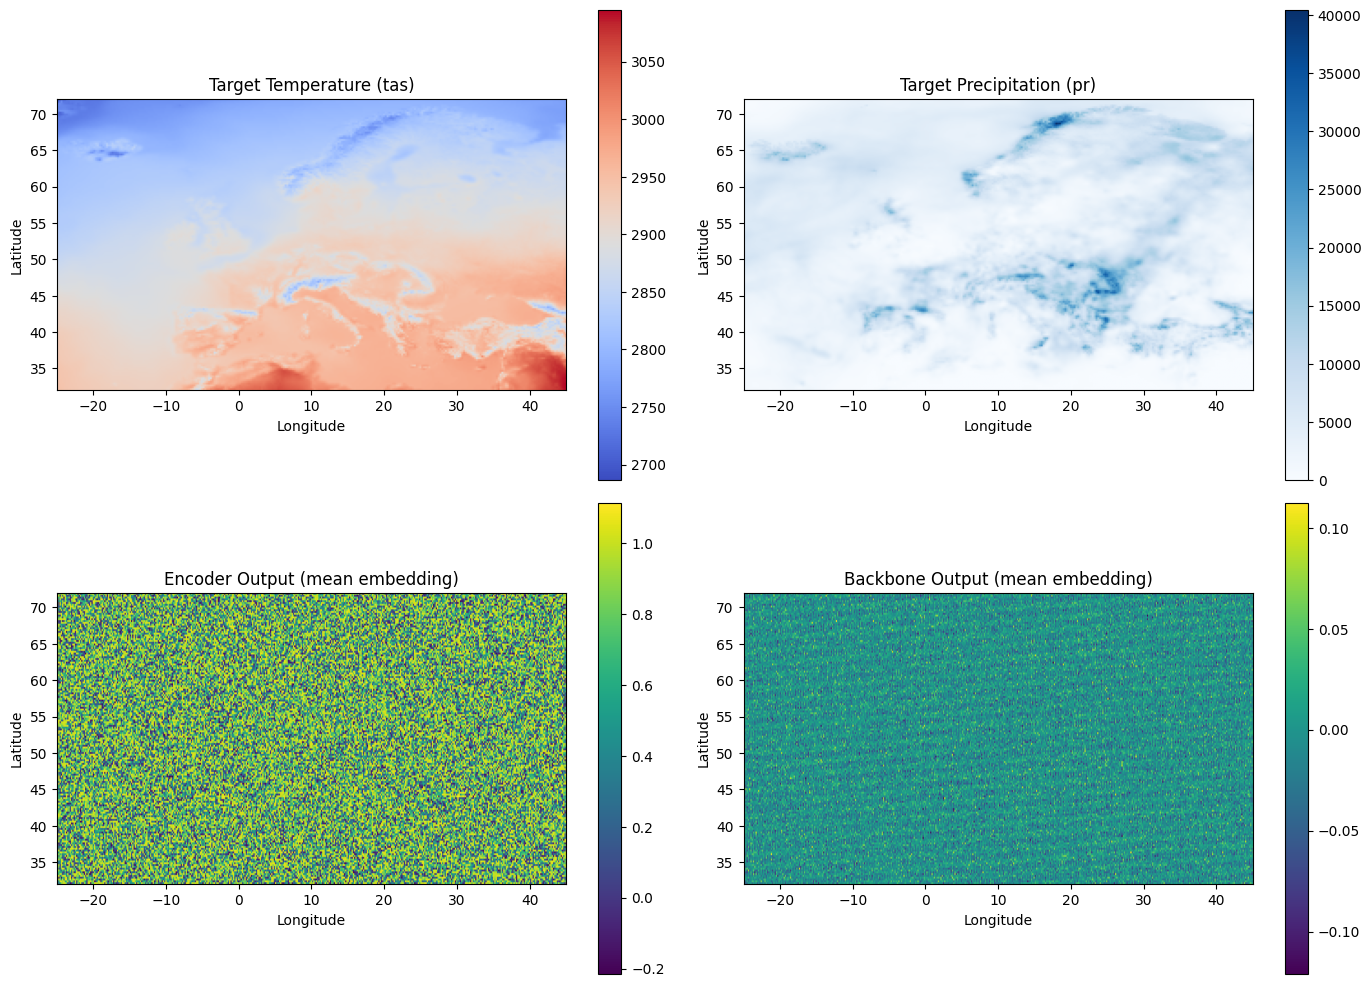

In [12]:
# Select a single timestep (e.g., the first one)
t_idx = 0

# Extract variables for plotting
# The number of grid cells in GRID_LAT and GRID_LON is 161 and 281, but ds['target'] has 44800 pixels per timestep.
# Let's check the correct shape for reshaping:
expected_shape = (len(GRID_LAT) - 1, len(GRID_LON) - 1)  # 160 x 280

target_tas = ds['target'][t_idx, :, 0].values.reshape(expected_shape)
target_pr = ds['target'][t_idx, :, 1].values.reshape(expected_shape)
# The encoder_output has 64400 pixels, but the grid is (161, 281).
# To reshape correctly, check if the pixel count matches the grid shape.
# If not, try reshaping to (len(GRID_LAT)-1, len(GRID_LON)-1) = (160, 280)
# The encoder_output and backbone_output have 64400 pixels, which matches (161, 400) or (280, 230), but not (160, 280).
# Let's check if (64400,) can be reshaped to (161, 400)
if ds['encoder_output'].shape[1] == 64400:
    encoder_output = ds['encoder_output'][t_idx].mean(dim='embedding_dim').values.reshape(161, 400)
    backbone_output = ds['backbone_output'][t_idx].mean(dim='embedding_dim').values.reshape(161, 400)
else:
    raise ValueError("Unexpected pixel count for encoder_output/backbone_output")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot target tas
im0 = axes[0, 0].imshow(target_tas, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap='coolwarm')
axes[0, 0].set_title('Target Temperature (tas)')
plt.colorbar(im0, ax=axes[0, 0])

# Plot target pr
im1 = axes[0, 1].imshow(target_pr, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap='Blues')
axes[0, 1].set_title('Target Precipitation (pr)')
plt.colorbar(im1, ax=axes[0, 1])

# Plot encoder output (mean over embedding_dim)
im2 = axes[1, 0].imshow(encoder_output, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap='viridis')
axes[1, 0].set_title('Encoder Output (mean embedding)')
plt.colorbar(im2, ax=axes[1, 0])

# Plot backbone output (mean over embedding_dim)
im3 = axes[1, 1].imshow(backbone_output, origin='lower', extent=[LON_START, LON_END, LAT_START, LAT_END], cmap='viridis')
axes[1, 1].set_title('Backbone Output (mean embedding)')
plt.colorbar(im3, ax=axes[1, 1])

for ax in axes.flat:
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()